# Loading remote images
This example will load a small region of data from a large image, once from the source .tif file, and once from the ome-zarr version.

Data from Jackson Lab's [Melanoma Patient-Derived Xenograft (PDX) data](https://images.jax.org/webclient/?show=project-1451).

Source image: https://images.jax.org/webclient/?show=image-364490


In [1]:
import tifffile
import ngff_zarr as nz
import matplotlib.pyplot as plt
import gcsfs
import numpy as np
import zarr

In [2]:
# Set up gcsfs for file-system like access to gcs
gcs_fs = gcsfs.GCSFileSystem() # Optional: project="my_project"

In [3]:
# Use the first URL for actual demo
image_tiff_url = "gs://ome-2025-test-data/ex1/M4007_T3_S2_AD.ome.tiff"
image_zarr_url = "gs://ome-2025-test-data/ex1/51990.zarr/0/"

### Reading an OME-TIFF
For "classic" image loading, we'll use [tifffile](https://github.com/cgohlke/tifffile/), a supurb python library for all things _TIFF_.

In [4]:
# Use tifffile to read the ome tiff
gcs_tiff_url = gcs_fs.open("gs://ome-2025-test-data/ex1/WM4007_T3_S2_AD.ome.tiff")
im = tifffile.TiffFile(gcs_tiff_url)
number_levels = len(im.series[0].levels)

In [5]:
# What's the shape of full resolution?
im.series[0].levels[0].shape

(3, 18026, 21215)

In [6]:
# And at level 4?
im.series[0].levels[4].shape

(3, 1126, 1325)

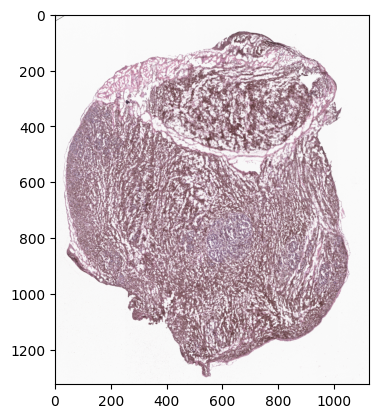

CPU times: user 183 ms, sys: 86.1 ms, total: 269 ms
Wall time: 1.04 s


(1325, 1126, 3)

In [7]:
%%time
# Load the low resolution data nad view it...
image = im.series[0].levels[4].pages[0].asarray()
image = image.transpose()
plt.imshow(image)
plt.show()
image.shape

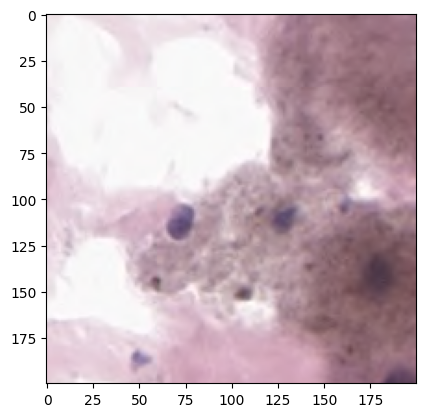

CPU times: user 12.8 s, sys: 11 s, total: 23.8 s
Wall time: 1min 53s


In [8]:
%%time
# Let's read a piece of the data at full res & render it
crop = im.series[0].levels[0].pages[0].asarray()[:,8100:8300,5000:5200]
crop = crop.transpose()
plt.imshow(crop)
plt.show()

### ...OME-TIFF, as a zarr?

In [9]:
# But there's another way, even with tiffile!
# tiffile can create a zarr view of the ome-tiff
# This maps the individual chunks inside the tiff to byte ranges,
# and can effeciently request just those ranges
gcs_tiff = gcs_fs.open("gs://ome-2025-test-data/ex1/WM4007_T3_S2_AD.ome.tiff")
im = tifffile.TiffFile(gcs_tiff)
tiff_zarr_store = im.series[0].levels[0].pages[0].aszarr()
tiff_zarr_array = zarr.open(tiff_zarr_store, mode='r')

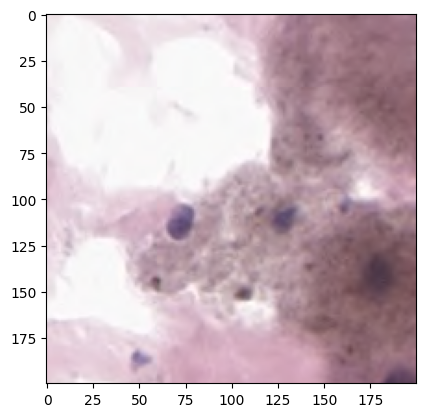

CPU times: user 500 ms, sys: 452 ms, total: 952 ms
Wall time: 4.25 s


In [10]:
%%time
# Read the same crop as above...
crop = tiff_zarr_array[:,8100:8300,5000:5200]
crop = crop.transpose()
plt.imshow(crop)
plt.show()

In [11]:
# Now, directly with zarr!

In [12]:
# Open the ome-zarr versions of the data using ngff-zarr
image_cloud = nz.from_ngff_zarr(image_zarr_url)

In [13]:
# Let's look at the shape of the full resolution image
# (This is courtesy of dask, which we'll discuss later)
image_cloud.images[0].data

dask.array<from-zarr, shape=(1, 3, 1, 18026, 21215), dtype=uint8, chunksize=(1, 3, 1, 1024, 1024), chunktype=numpy.ndarray>

In [14]:
# Crop the image -- and see the underlying shape
crop = image_cloud.images[0].data[0,:,0,8100:8300,5000:5200]
# Also, let's invert the axis from C,Y,X to X,Y,C
crop = crop.transpose()
crop

dask.array<transpose, shape=(200, 200, 3), dtype=uint8, chunksize=(120, 108, 3), chunktype=numpy.ndarray>

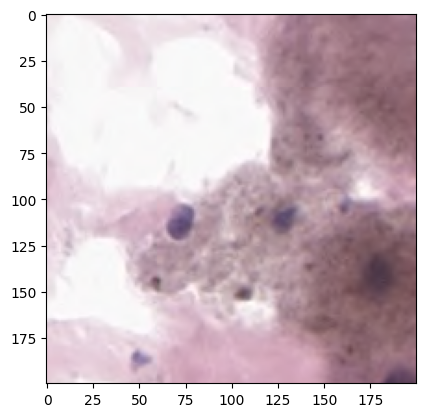

CPU times: user 311 ms, sys: 206 ms, total: 517 ms
Wall time: 1.35 s


In [15]:
%%time
# Actually fetch the data & render it
crop_data = crop.compute()
plt.imshow(crop_data)
plt.show()

In [16]:
# What about the zoomed out version? Let's see how long that takes with zarr
image = image_cloud.images[4].data[0,:,0,:,:]

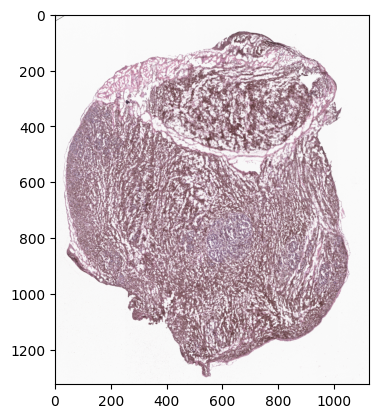

CPU times: user 280 ms, sys: 147 ms, total: 426 ms
Wall time: 1.3 s


In [17]:
%%time
image_data = image.compute()
image_data = image.transpose()
plt.imshow(image_data)
plt.show()